In [37]:
import datetime
import math
import numpy as np
import pandas as pd
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
import plotly.graph_objects as go
import matplotlib.pyplot as plt


In [38]:
df = pd.read_csv('National_Bridge_Inventory.csv')


/Users/evanmacayeal/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning:

Columns (8,12,14,24,38,43,44,45,46,78,80,82,103,105,109,114,115,116,127) have mixed types. Specify dtype option on import or set low_memory=False.



In [39]:
state_code_abbrev_map = pd.read_csv('State_Codes.csv').set_index('Code').to_dict()['Abbrev']
state_code_name_map = pd.read_csv('State_Codes.csv').set_index('Code').to_dict()['State']


In [40]:
curr_year = float(datetime.datetime.now().year)
df['Age'] = [curr_year - yr for yr in df['YEAR_BUILT_027']]


In [41]:
agg_data = pd.DataFrame()
sdf = df[df['STATE_CODE_001'] != 66].dropna(subset=['Age']) # no state code in documentation for 66
sdf = sdf[sdf['HISTORY_037'] == 5] # no historical bridges otherwise skews age

agg_data['avg age'] = round(sdf.groupby('STATE_CODE_001')['Age'].mean(),2)
agg_data['median age'] = round(sdf.groupby('STATE_CODE_001')['Age'].median(),2)
agg_data['youngest'] = sdf.groupby('STATE_CODE_001')['Age'].min().astype(int)
agg_data['oldest'] = sdf.groupby('STATE_CODE_001')['Age'].max().astype(int)
agg_data['num of bridges'] = sdf.groupby('STATE_CODE_001')['Age'].count().astype(int)
agg_data.index = [state_code_abbrev_map[x] for x in agg_data.index]

agg_data.head()

,avg age,median age,youngest,oldest,num of bridges
AL,49.07,51.0,3,123,15965
AK,37.01,38.0,4,101,1092
AZ,45.35,45.0,4,121,8156
AR,46.83,49.0,4,102,8099
CA,52.30,54.0,4,161,24105


In [42]:
for col in agg_data.columns:
    agg_data[col] = agg_data[col].astype(str)

agg_data['fig_text'] = agg_data.index + '<br>' + \
    'Num of bridges ' + agg_data['num of bridges'] + ' Avg Age ' + agg_data['avg age'] + '<br>' + \
    'Youngest ' + agg_data['youngest'] + ' Oldest ' + agg_data['oldest']


fig = go.Figure(data=go.Choropleth(
    locations=agg_data.index,
    z=agg_data['median age'].astype(float),
    locationmode='USA-states',
    colorscale='Reds',
    autocolorscale=False,
    text=agg_data['fig_text'], # hover text
    marker_line_color='white', # line markers between states
    colorbar_title="Years"
))

fig.update_layout(
    title_text='US Median Bridge Age by State<br>(Hover for details)',
    geo = dict(
        scope='usa',
        projection=go.layout.geo.Projection(type = 'albers usa'),
        showlakes=True, # lakes
        lakecolor='rgb(255, 255, 255)'),
)

fig.show()


In [43]:
fig = go.Figure(data=go.Choropleth(
    locations=agg_data.index,
    z=agg_data['avg age'].astype(float),
    locationmode='USA-states',
    colorscale='Reds',
    autocolorscale=False,
    text=agg_data['fig_text'], # hover text
    marker_line_color='white', # line markers between states
    colorbar_title="Years"
))

fig.update_layout(
    title_text='US Average Bridge Age by State<br>(Hover for details)',
    geo = dict(
        scope='usa',
        projection=go.layout.geo.Projection(type = 'albers usa'),
        showlakes=True, # lakes
        lakecolor='rgb(255, 255, 255)'),
)

fig.show()


In [44]:
cali_df = sdf[sdf['STATE_CODE_001'] == 6] # state code for California
cali_df = cali_df[cali_df['X'] != 0] # no garbage coordinates


In [45]:
cali_map = gpd.read_file('cb_2018_06_cousub_500k.shp')
crs = {'init': 'epsg:4326'}
geometry = [Point(xy) for xy in zip(cali_df['X'],cali_df['Y'])]
geo_df = gpd.GeoDataFrame(cali_df, crs=crs, geometry=geometry)
geo_df.head()


/Users/evanmacayeal/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



,X,Y,OBJECTID,STATUS,DATE,LONGDD,LATDD,STATE_CODE_001,STRUCTURE_NUMBER_008,RECORD_TYPE_005A,...,SCOUR_CRITICAL_113,FUTURE_ADT_114,YEAR_OF_FUTURE_ADT_115,MIN_NAV_CLR_MT_116,FED_AGENCY,CAT10,CAT23,CAT29,Age,geometry
103282,-124.051719,41.545656,103283,MM,603,-124.051719,41.545656,6,01 0002,1,...,8,6937.0,2035.0,NaN,N,F,5,240,64.0,POINT (-124.05172 41.54566)
103283,-124.059000,41.558094,103284,AM,1202,-124.059000,41.558094,6,01 0003,1,...,4,6937.0,2034.0,NaN,N,F,5,316,70.0,POINT (-124.05900 41.55809)
103284,-124.069039,41.568356,103285,AM,1202,-124.069039,41.568356,6,01 0004,1,...,8,6937.0,2035.0,NaN,N,F,5,372,64.0,POINT (-124.06904 41.56836)
103285,-124.101011,41.604578,103286,AM,1202,-124.101011,41.604578,6,01 0005,1,...,8,6121.0,2034.0,NaN,N,G,7,1646,64.0,POINT (-124.10101 41.60458)
103286,-124.082533,41.806692,103287,AM,1202,-124.082533,41.806692,6,01 0006,1,...,8,6019.0,2036.0,NaN,N,G,7,2544,31.0,POINT (-124.08253 41.80669)


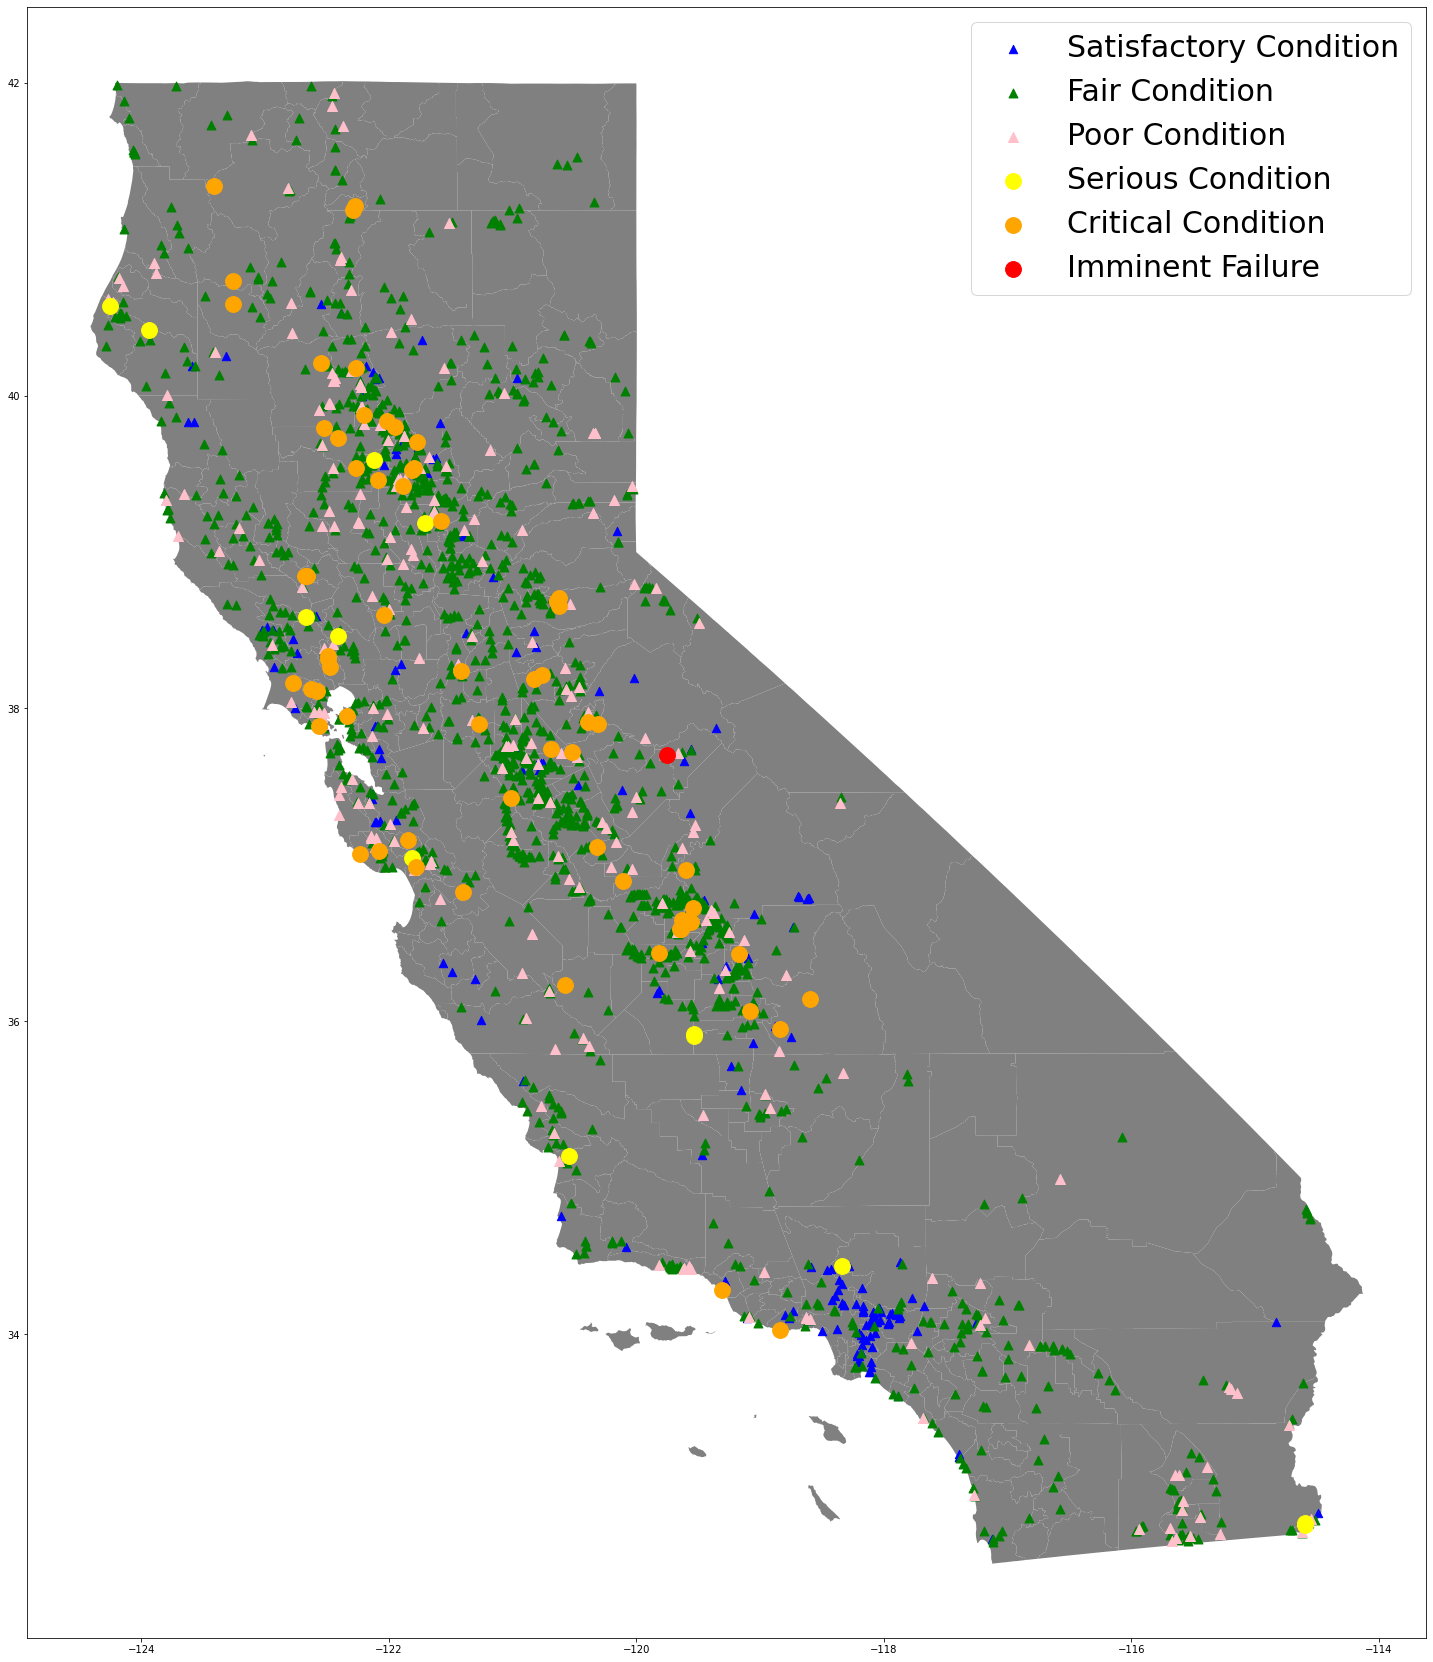

In [46]:
fig,ax = plt.subplots(figsize=(30,30))
cali_map.plot(ax=ax, color='grey')
geo_df[(geo_df['Age'] > 60) & (geo_df['SUBSTRUCTURE_COND_060'] == '6')].plot(ax=ax, markersize=70, color='blue', marker="^", label='Satisfactory Condition')
geo_df[(geo_df['Age'] > 60) & (geo_df['SUBSTRUCTURE_COND_060'] == '5')].plot(ax=ax, markersize=80, color='green', marker="^", label='Fair Condition')
geo_df[(geo_df['Age'] > 60) & (geo_df['SUBSTRUCTURE_COND_060'] == '4')].plot(ax=ax, markersize=100, color='pink', marker="^", label='Poor Condition')
geo_df[(geo_df['Age'] > 60) & (geo_df['SUBSTRUCTURE_COND_060'] == '3')].plot(ax=ax, markersize=250, color='yellow', marker="o", label='Serious Condition')
geo_df[(geo_df['Age'] > 60) & (geo_df['SUBSTRUCTURE_COND_060'] == '2')].plot(ax=ax, markersize=250, color='orange', marker="o", label='Critical Condition')
geo_df[(geo_df['Age'] > 60) & (geo_df['SUBSTRUCTURE_COND_060'] == '1')].plot(ax=ax, markersize=250, color='red', marker="o", label='Imminent Failure')
plt.legend(prop={'size':30})
